In [1]:
!pip install gdown
!pip install tensorflow-gpu

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [44]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
df = pd.read_csv(
  "/content/dane.csv", sep = ";",

)

In [54]:
df.shape

(15506, 19)

In [97]:
df['data'] = pd.to_datetime(df['data'], infer_datetime_format=True)
df['godz'] = pd.to_datetime(df['godz'].dt.strftime("%H:%M:%S"))
df["Timestamp"] = df['data'] = pd.to_datetime(df["data"], format='%d-%m-%Y').dt.strftime('%Y-%m-%d') + ' ' + df["godz"].dt.strftime('%H:%M:%S')
df["Timestamp"] = df["Timestamp"].astype(str)
# Przenieś kolumnę "Timestamp_i_godz" na pierwszą pozycję
df.insert(0, 'Timestamp', df.pop('Timestamp'))

In [98]:
df.head()

,Timestamp,data,fixing_i_price_PLN,24h,48h,72h,96h,120h,144h,168h,hour,day_of_week,Generation - Wind Onshore [MW] Day Ahead/ BZN|PL,Day-ahead Total Load Forecast [MW] - BZN|PL,Scheduled Generation [MW] (D) - BZN|PL,day_of_month,month,year,season,godz
0,2018-03-26 00:00:00,2018-03-26 00:00:00,154.69,-0.865257,159.37,162.06,146.54,158.72,149.90,-0.939246,-0.916667,-0.75,-0.171620,-0.660377,-0.578891,26.0,3.0,2018.0,Wiosna,2024-01-13 00:00:00
1,2018-03-26 01:00:00,2018-03-26 01:00:00,166.60,-0.791662,160.00,164.00,147.05,161.00,150.10,-0.838386,-0.833333,-0.75,-0.181278,-0.735849,-0.691631,26.0,3.0,2018.0,Wiosna,2024-01-13 01:00:00
2,2018-03-26 02:00:00,2018-03-26 02:00:00,190.06,-0.791541,162.19,174.80,160.00,167.60,162.26,-0.821437,-0.750000,-0.75,-0.210253,-0.773585,-0.743337,26.0,3.0,2018.0,Wiosna,2024-01-13 02:00:00
3,2018-03-26 03:00:00,2018-03-26 03:00:00,228.30,-0.778248,167.70,186.67,173.02,183.47,185.01,-0.417761,-0.666667,-0.75,-0.236999,-0.726415,-0.692164,26.0,3.0,2018.0,Wiosna,2024-01-13 03:00:00
4,2018-03-26 04:00:00,2018-03-26 04:00:00,272.37,-0.688459,174.90,291.01,200.37,230.00,235.00,0.074003,-0.583333,-0.75,-0.256315,-0.622642,-0.582090,26.0,3.0,2018.0,Wiosna,2024-01-13 04:00:00


array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>],
      dtype=object)

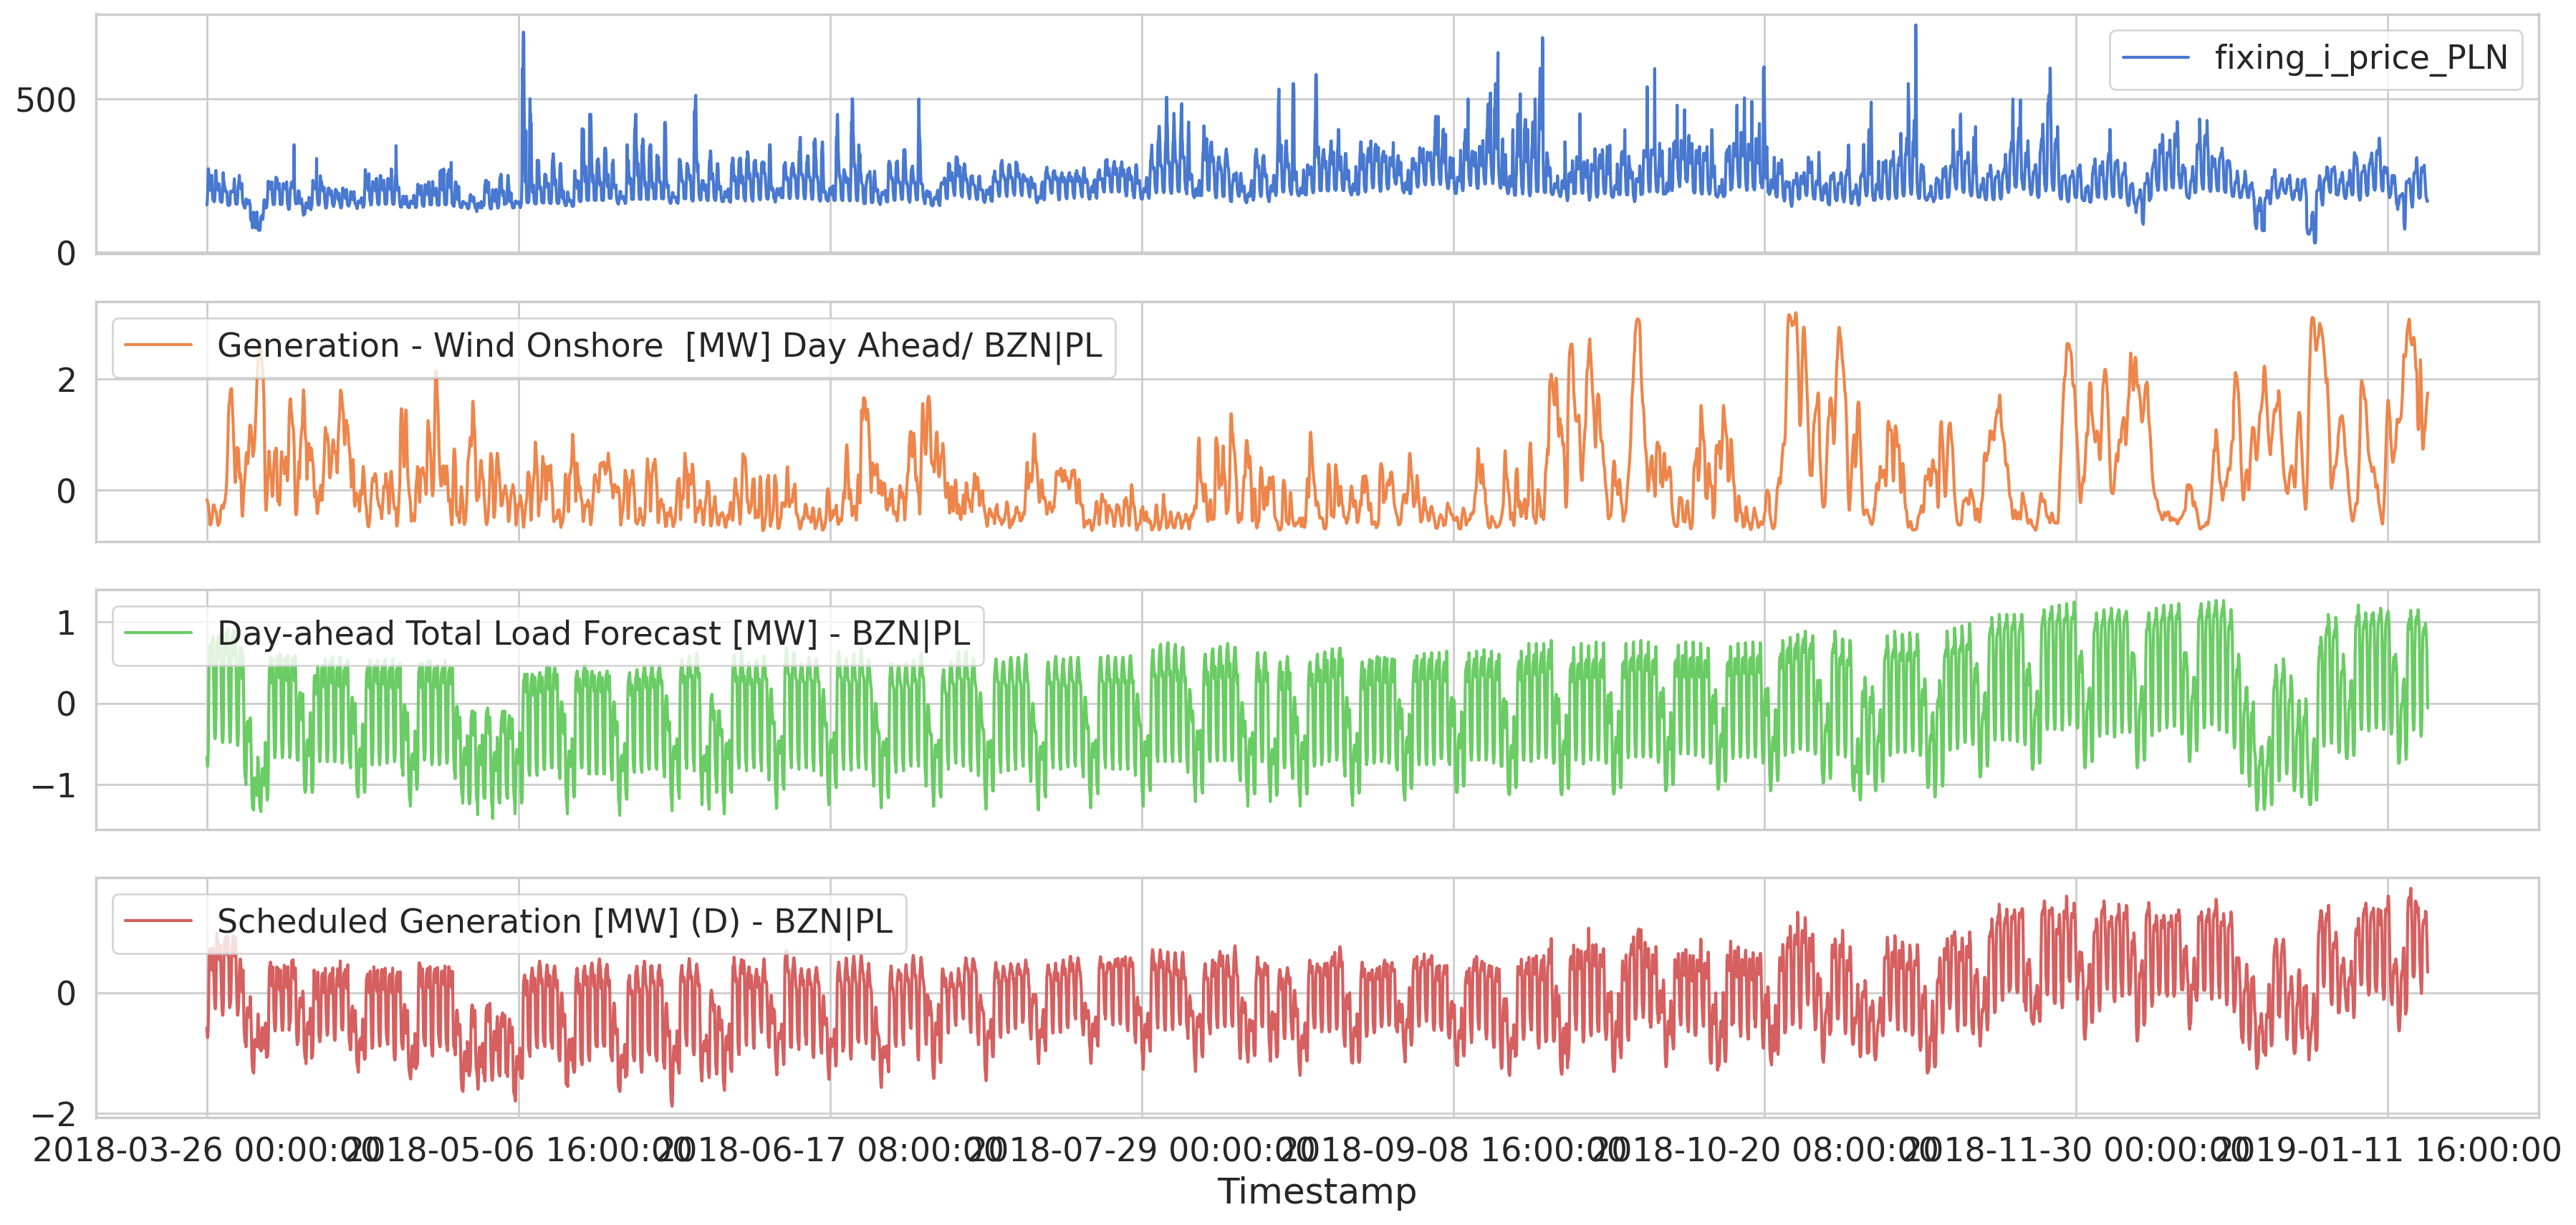

In [99]:
df.set_index('Timestamp')[['fixing_i_price_PLN','Generation - Wind Onshore  [MW] Day Ahead/ BZN|PL', 'Day-ahead Total Load Forecast [MW] - BZN|PL', 'Scheduled Generation [MW] (D) - BZN|PL']].plot(subplots=True)

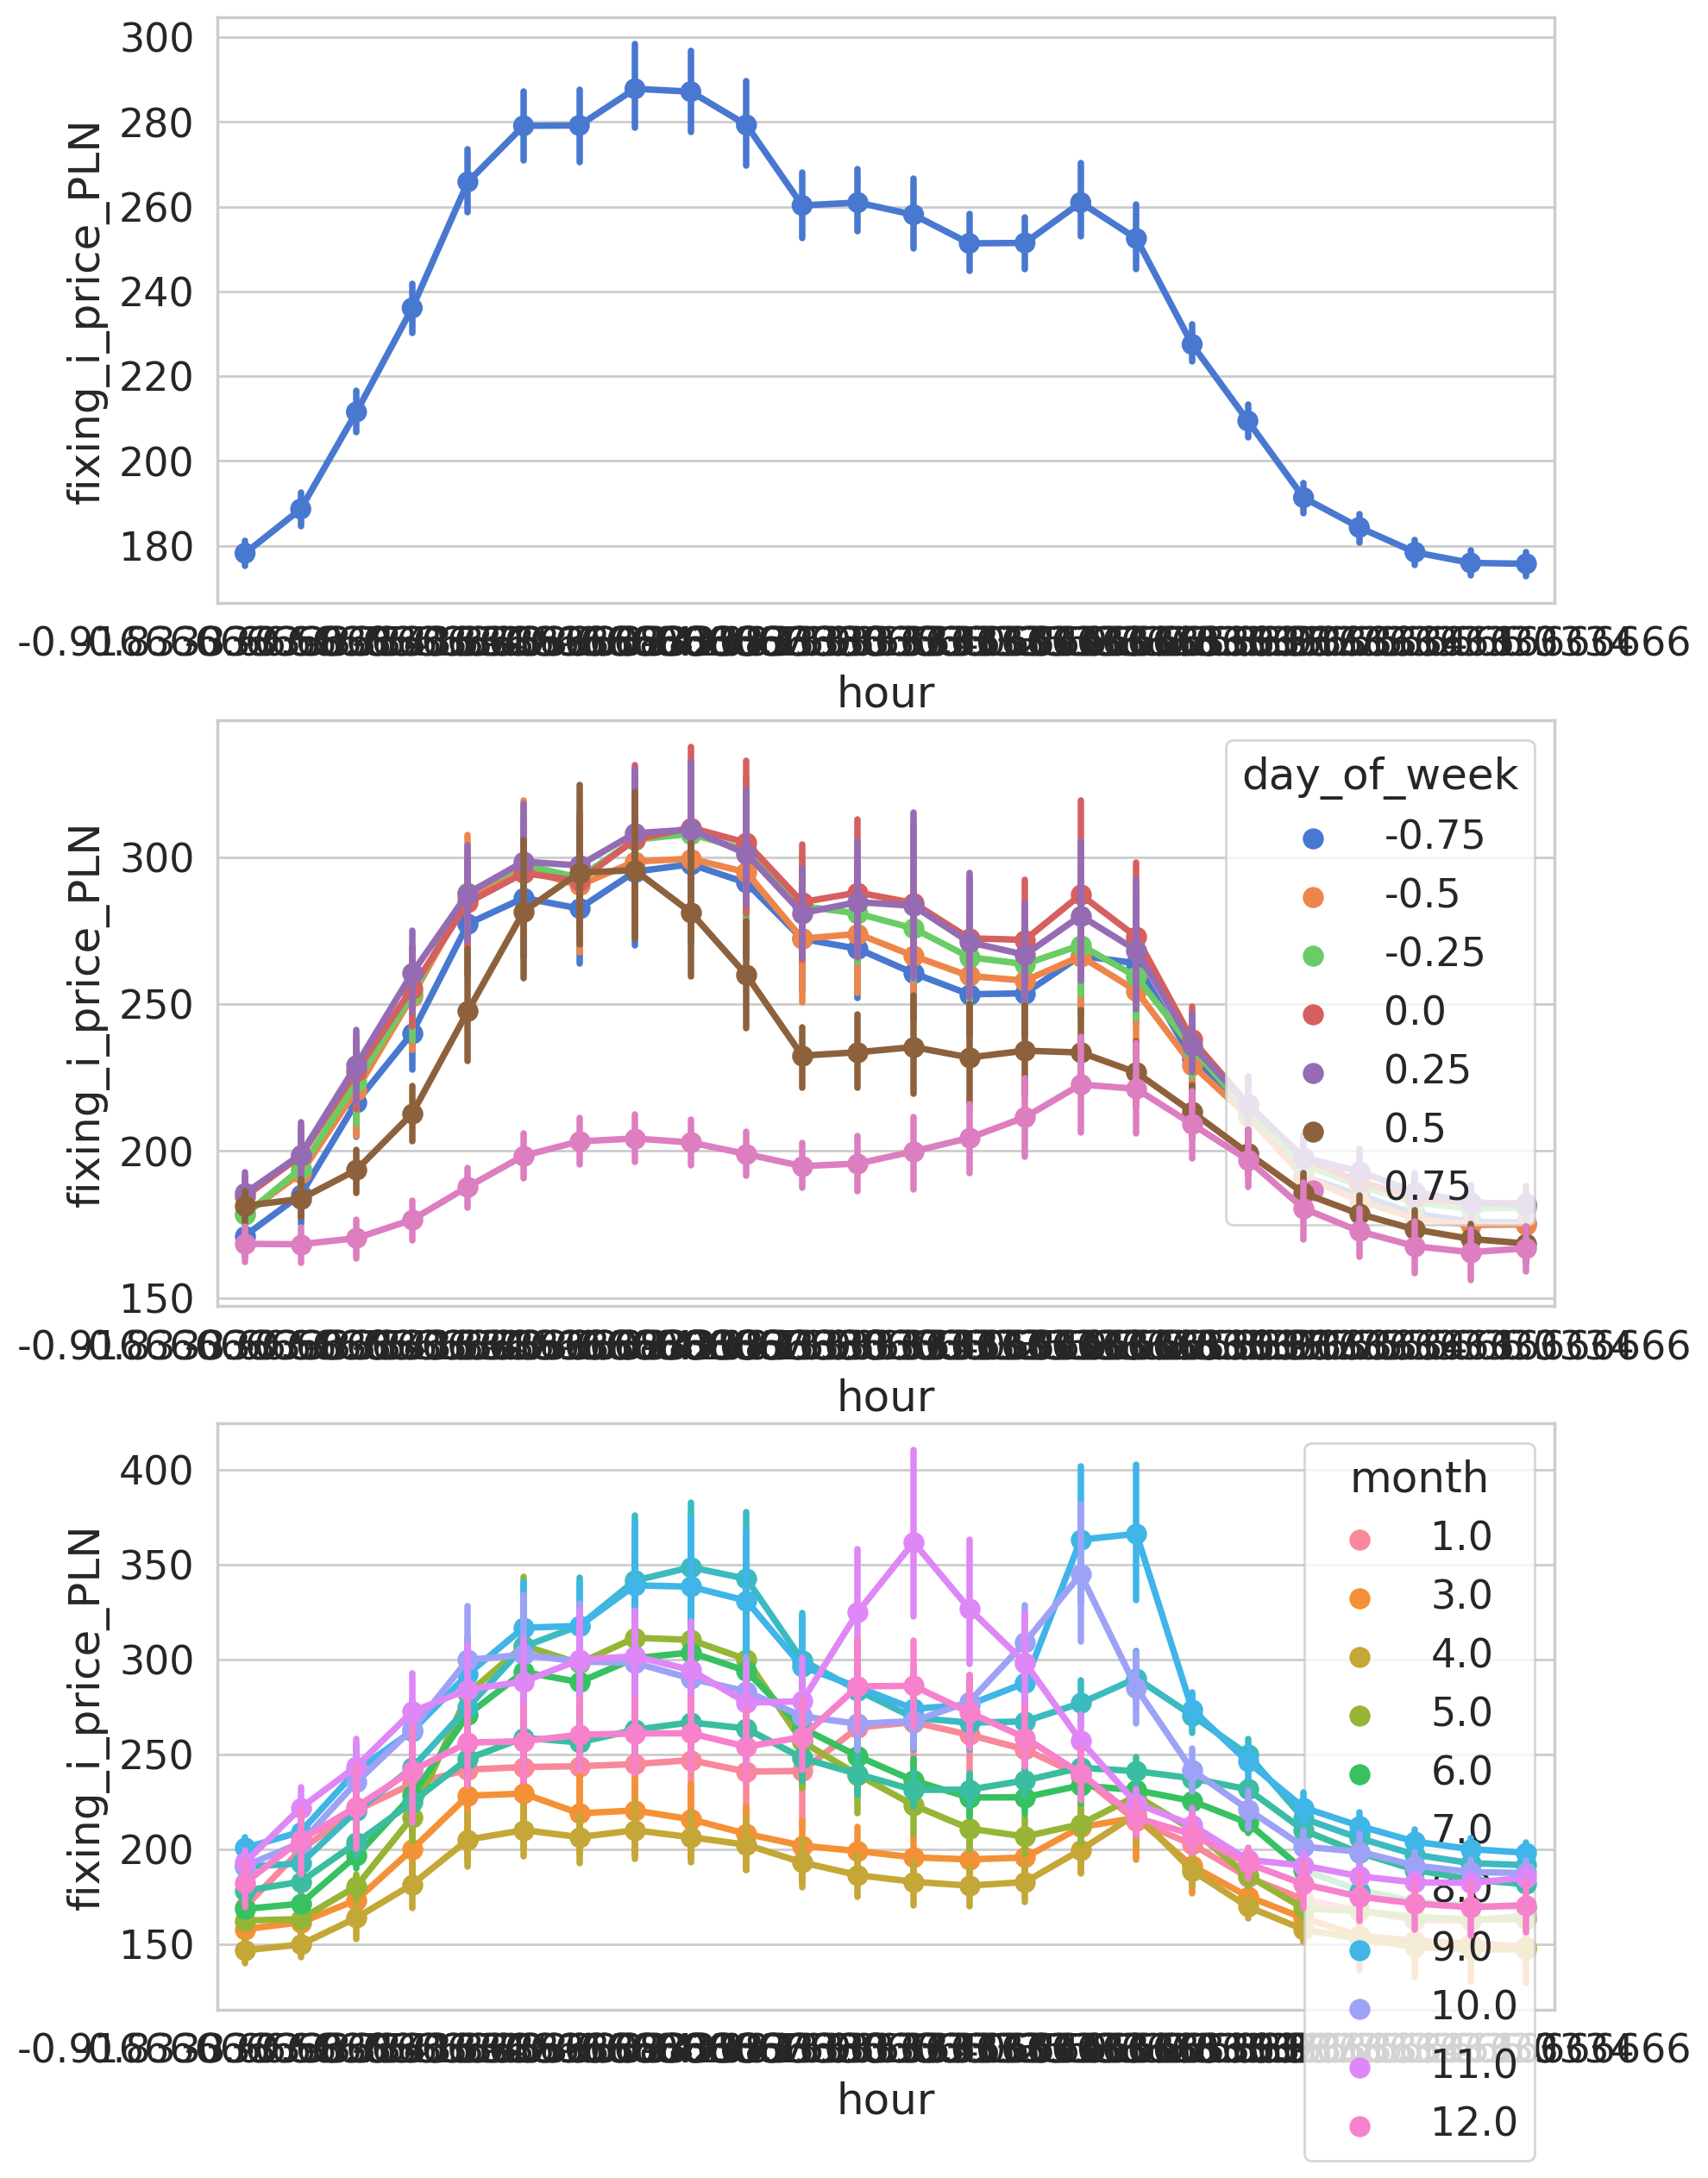

In [100]:
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')

# Tworzenie wykresów z podziałem
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
fig.set_size_inches(10, 15)

sns.pointplot(data=df, x='hour', y='fixing_i_price_PLN', ax=ax1)
sns.pointplot(data=df, x='hour', y='fixing_i_price_PLN', hue='day_of_week', ax=ax2)
sns.pointplot(data=df, x='hour', y='fixing_i_price_PLN', hue='month', ax=ax3)

plt.show()

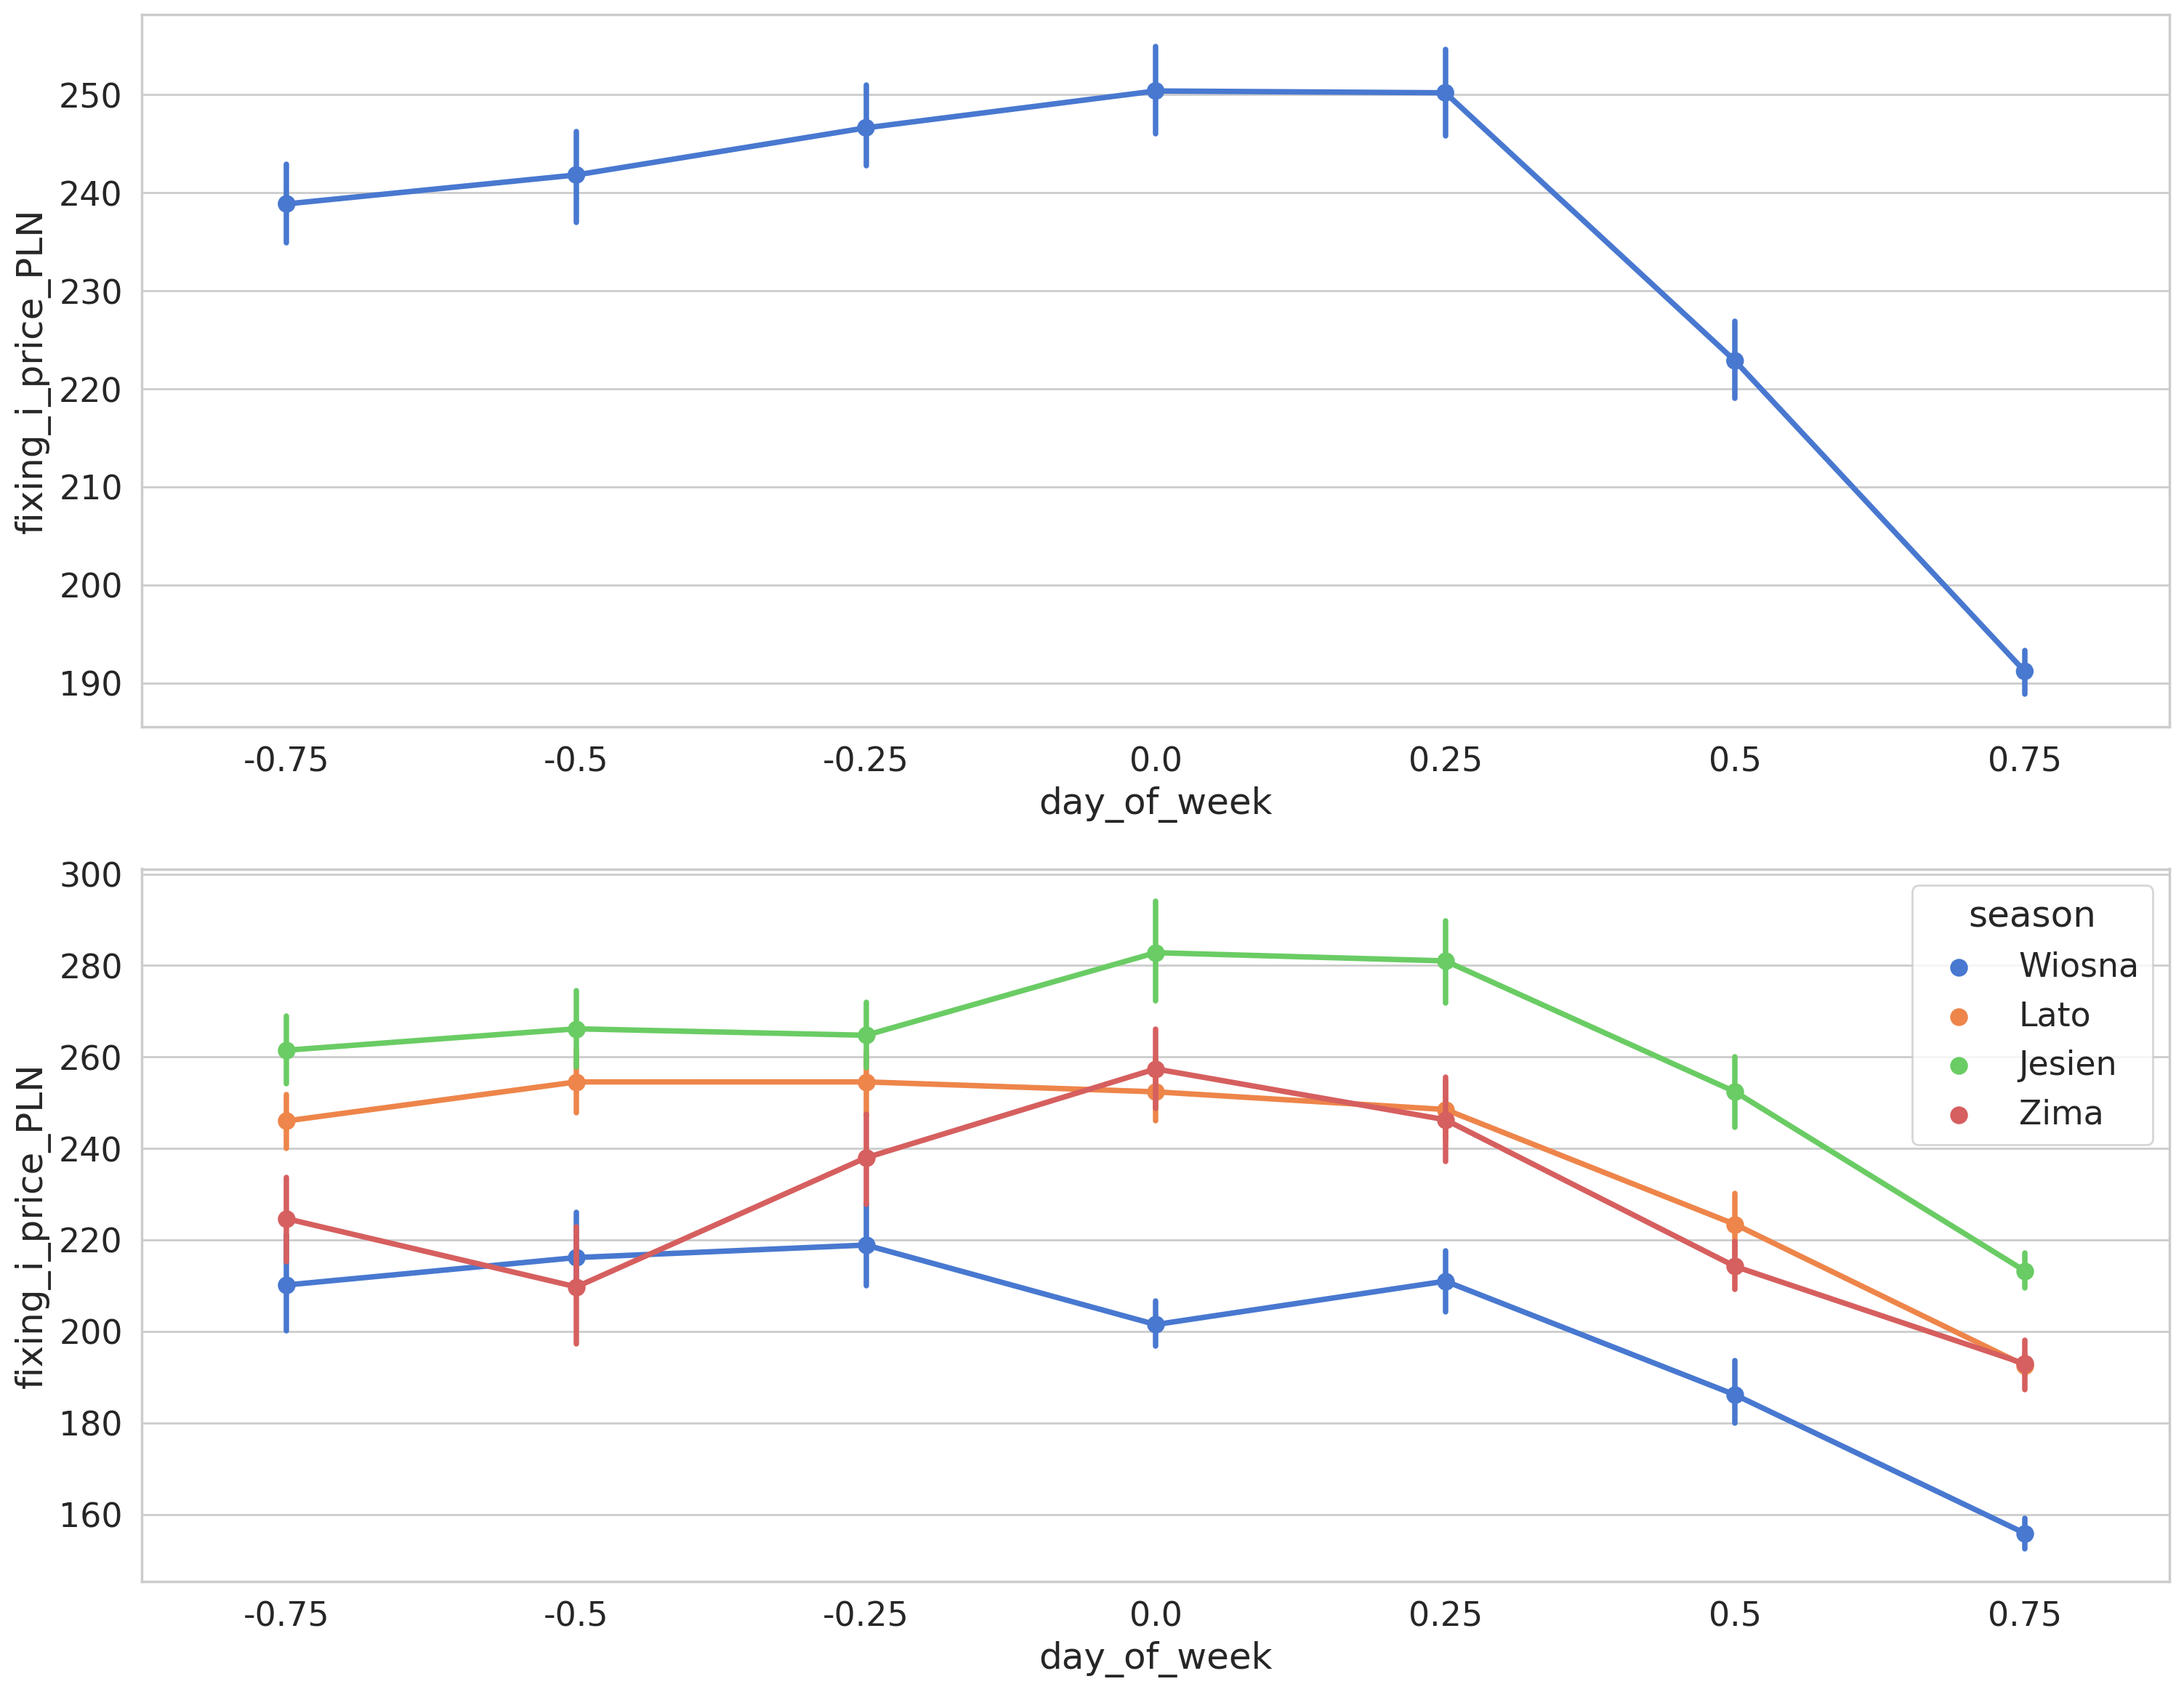

In [101]:
# Tworzenie wykresów z podziałem
fig, (ax1, ax2) = plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='fixing_i_price_PLN', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='fixing_i_price_PLN', hue='season', ax=ax2)

plt.show()

In [102]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

13955 1551


# Preprocessing

In [103]:
from sklearn.preprocessing import RobustScaler

f_columns = ['Generation - Wind Onshore  [MW] Day Ahead/ BZN|PL', 'Day-ahead Total Load Forecast [MW] - BZN|PL', 'Scheduled Generation [MW] (D) - BZN|PL','24h','168h', 'hour','day_of_week']

f_transformer = RobustScaler()
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)
test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)
fixing_i_price_PLN_transformer = RobustScaler()
fixing_i_price_PLN_transformer = fixing_i_price_PLN_transformer.fit(train[['fixing_i_price_PLN']])
train['fixing_i_price_PLN'] = fixing_i_price_PLN_transformer.transform(train[['fixing_i_price_PLN']])
test['fixing_i_price_PLN'] = fixing_i_price_PLN_transformer.transform(test[['fixing_i_price_PLN']])

<ipython-input-103-c7e2f0ad8639>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, f_columns] = f_transformer.transform(
<ipython-input-103-c7e2f0ad8639>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, f_columns] = f_transformer.transform(
<ipython-input-103-c7e2f0ad8639>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [104]:

def create_Timestampset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [105]:
time_steps = 21

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_Timestampset(train, train.fixing_i_price_PLN, time_steps)
X_test, y_test = create_Timestampset(test, test.fixing_i_price_PLN, time_steps)

print(X_train.shape, y_train.shape)

(13934, 21, 20) (13934,)


In [106]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [107]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [94]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

NameError: name 'history' is not defined

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = fixing_i_price_PLN_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = fixing_i_price_PLN_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = fixing_i_price_PLN_transformer.inverse_transform(y_pred)

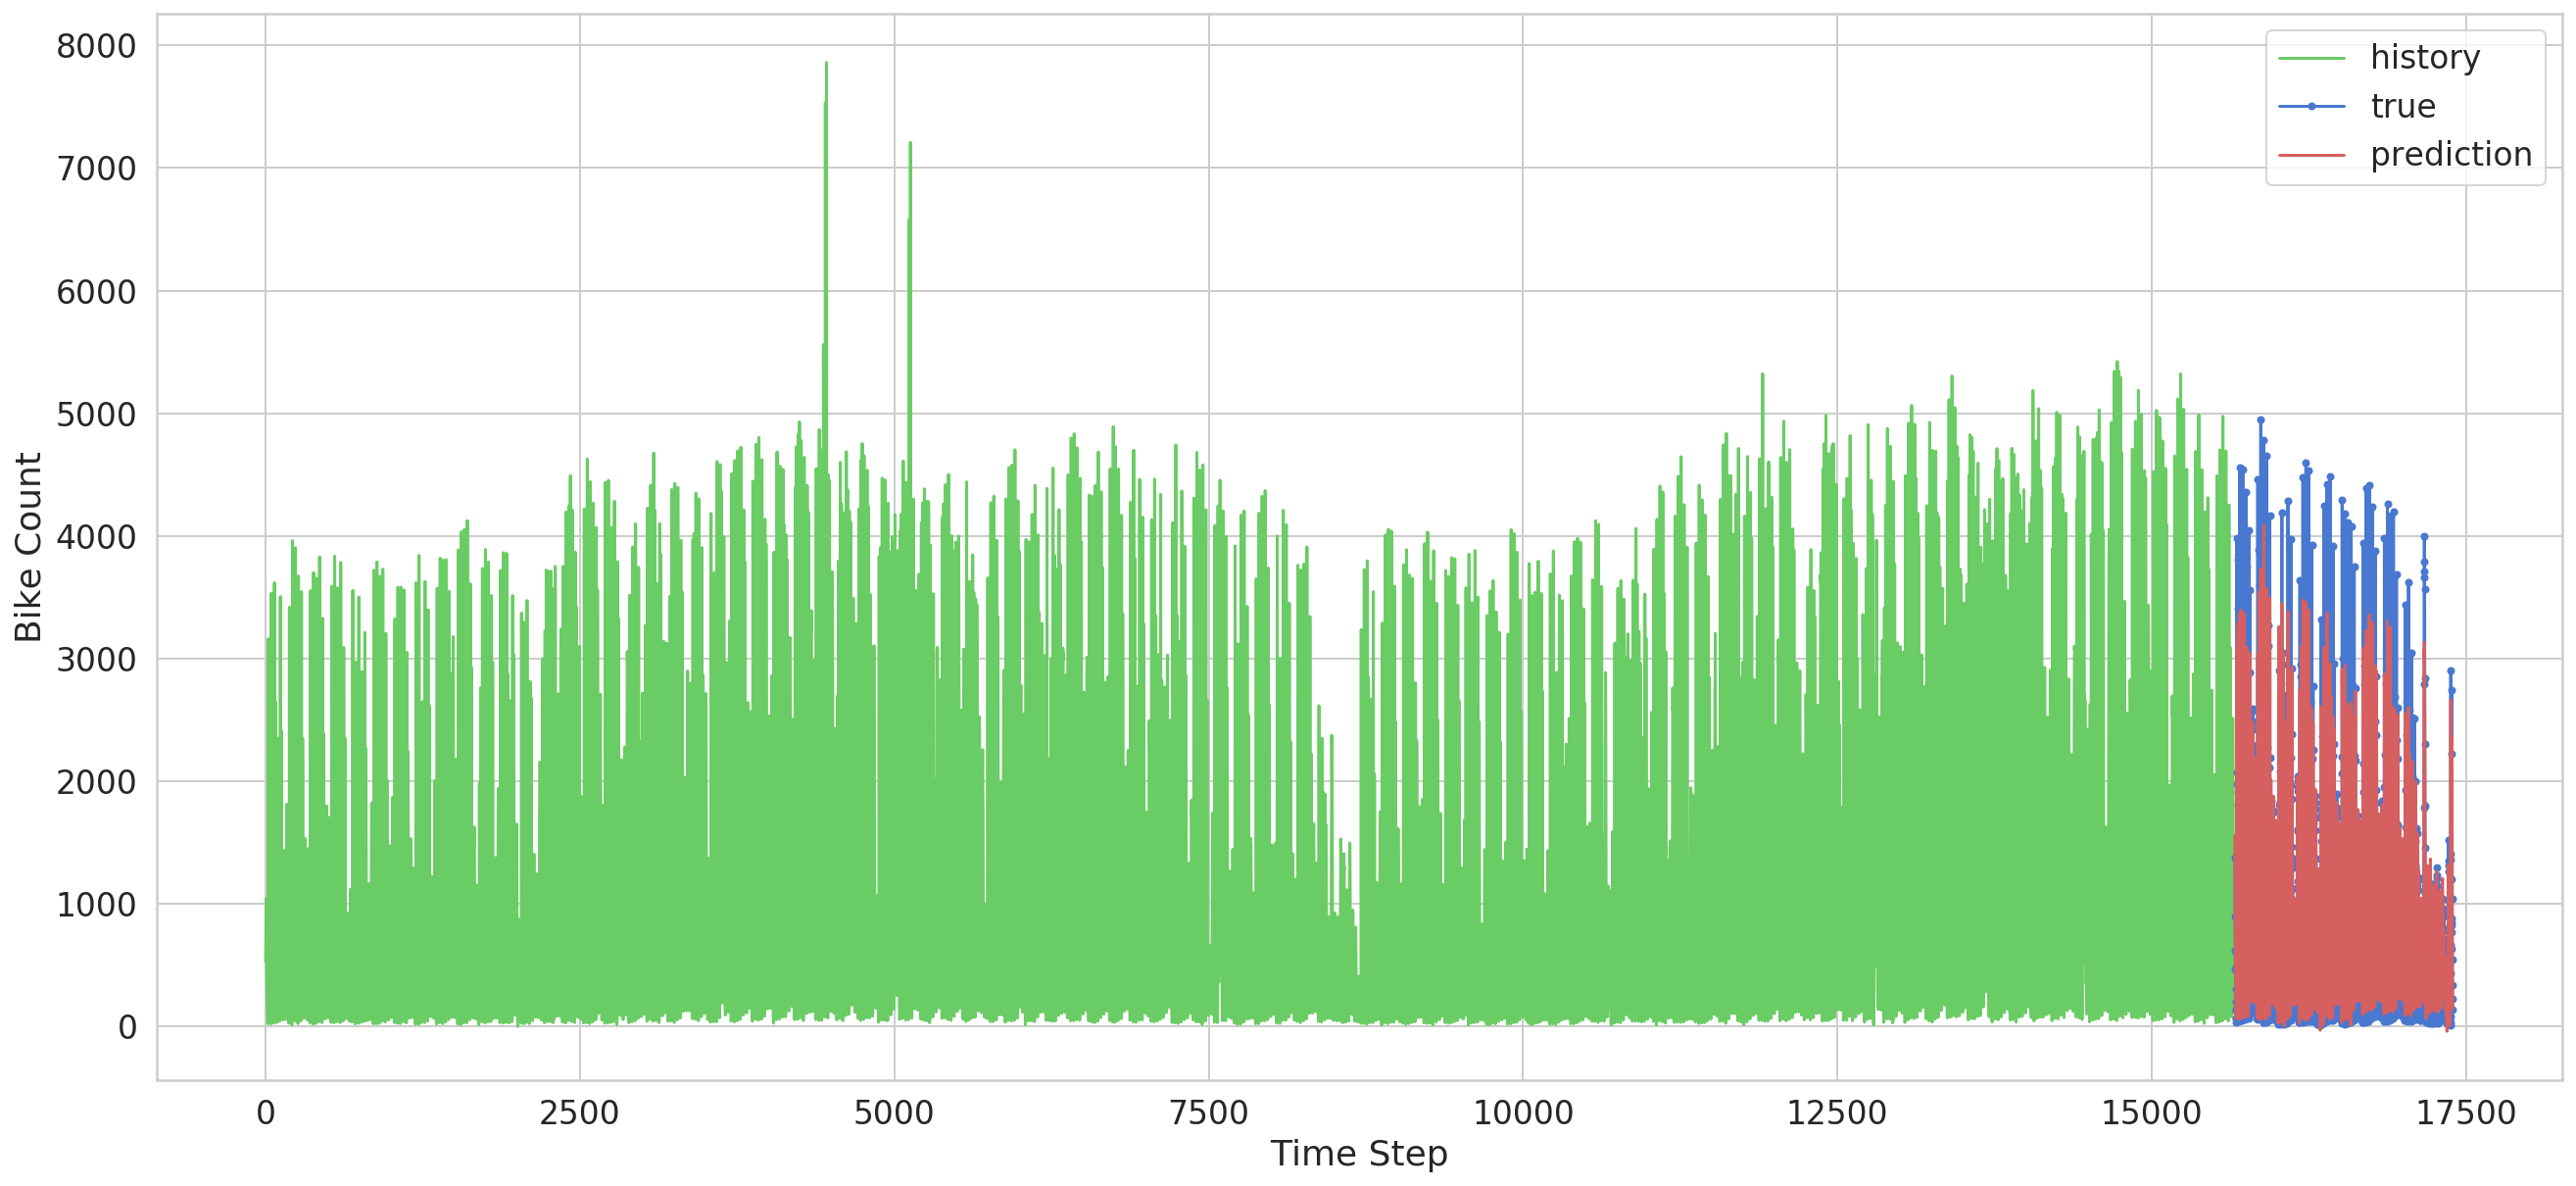

In [ ]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

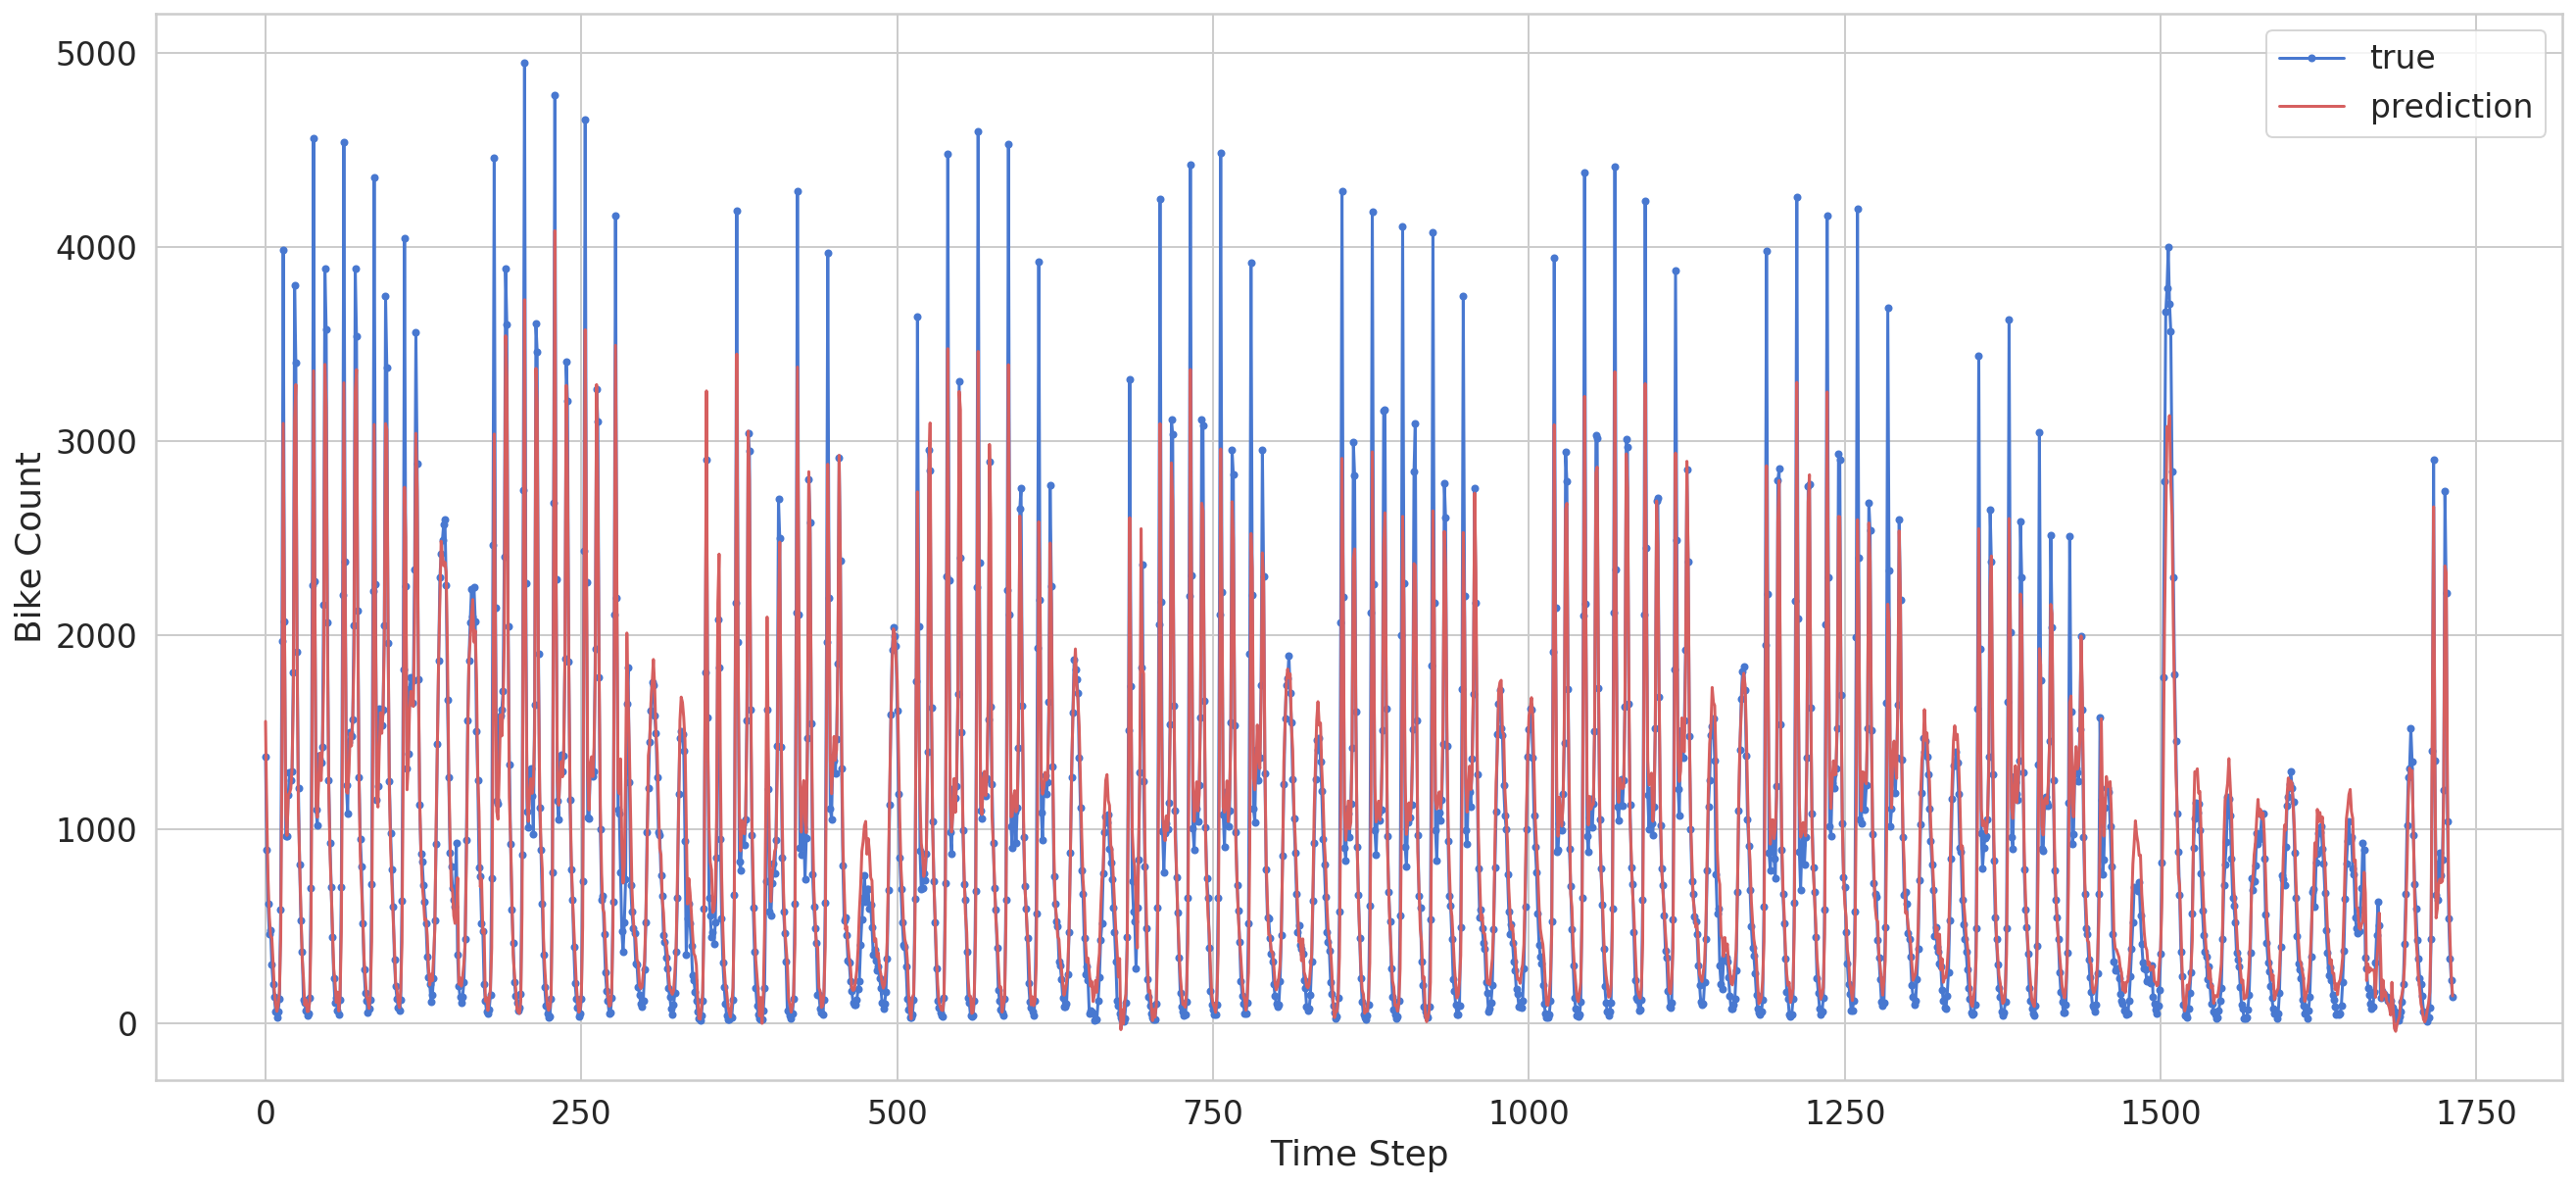

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();